In [1]:
#install CLIP
#!pip install git+https://github.com/openai/CLIP.git

In [2]:
import torch
from tqdm.notebook import trange
from matplotlib import pyplot as plt

import clip
from criteria.clip_loss import CLIPLoss
from criteria.id_loss import IDLoss
from models.stylegan2.model import Generator


In [3]:
# download styleGAN2 weights and ArcFace weights

In [4]:
stylegan_size = 1024
stylegan_path = 'stylegan2-ffhq-config-f.pt'
ir_se50_weights = "model_ir_se50.pth"

In [5]:
clip_loss = CLIPLoss(stylegan_size)
id_loss = IDLoss(ir_se50_weights)

Loading ResNet ArcFace


In [6]:
description = 'blonde hair'
text_inputs = clip.tokenize(description).cuda()

In [7]:
gen = Generator(stylegan_size, 512, 8)
gen.load_state_dict(torch.load(stylegan_path)["g_ema"], strict=False)
gen.eval()
gen = gen.cuda()
mean_latent = gen.mean_latent(4096)

In [8]:
latent_code_init_not_trunc = torch.randn(1, 512).cuda()

with torch.no_grad():
    img_orig, latent_code_init, _ = gen([latent_code_init_not_trunc], return_latents=True,
                                  truncation=0.7, truncation_latent=mean_latent)
# with torch.no_grad():
#     img_orig, _ = gen([latent_code_init], input_is_latent=True, randomize_noise=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


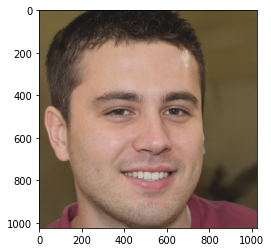

In [9]:
def draw_img(img):
    with torch.no_grad():
        return plt.imshow(img[0].cpu().transpose(0,2).transpose(1,0)/2.4752+0.5)
draw_img(img_orig)

In [10]:
latent_code_init = latent_code_init.detach()
latent = latent_code_init.detach().clone()
latent.requires_grad = True

In [11]:
lr_rampup = 0.05
lr = 0.1
num_steps = 100
l2_lambda = 0.005
id_lambda = 0.


optimizer = torch.optim.Adam([latent], lr=lr)

In [ ]:
clip_hist = []
idl_hist = []
l2_hist = []
lr_0 = lr

for i in trange(num_steps):
    lr = lr_0-(1-i/num_steps)*lr_rampup
    
    optimizer.param_groups[0]["lr"] = lr

    img_gen, _ = gen([latent], input_is_latent=True, randomize_noise=False)

    c_loss = clip_loss(img_gen, text_inputs)
    clip_hist.append(c_loss.item())

    if id_lambda > 0:
        i_loss = id_loss(img_gen, img_orig)[0]
        idl_hist.append(i_loss.item()*id_lambda)
    else:
        i_loss = 0
        
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    l2_hist.append(l2_loss.item()*l2_lambda)
    
    loss = c_loss + l2_lambda * l2_loss + id_lambda * i_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
    img_gen, _ = gen([latent], input_is_latent=True, randomize_noise=False)
    draw_img(img_gen)

In [ ]:
plt.plot(clip_hist, label='clip')
plt.plot(idl_hist, label='id')
plt.plot(l2_hist, label='L2')
plt.legend()